## 1. Generate Dataset 

In [1]:
# create connection between mysql with jupyter notebook
import mysql.connector
import pandas as pd

mydb = mysql.connector.connect(host="127.0.0.1", user="root", password="", database="x-da")
mycursor = mydb.cursor()

def fetch(sql):
    mycursor.execute(sql)
    result = mycursor.fetchall()
    result = pd.DataFrame(result)
    
    return result

In [2]:
# show tables in working database
fetch("SHOW TABLES")

,0
0,ds1
1,ds2
2,ljoin_dataset


In [3]:
# query for description dataset1
fetch("DESC ds1")

,0,1,2,3,4,5
0,dt,date,YES,,None,
1,tm,time,YES,,None,
2,user_id,varchar(255),YES,,None,
3,session_id,varchar(255),YES,,None,
4,screen_id,varchar(255),YES,,None,


In [4]:
# query top records in dataset1
fetch('SELECT * FROM ds1 LIMIT 5')

,0,1,2,3,4
0,2017-08-01,0 days 05:52:00,7462310,fac31b39-7e78-45d7-bccc-f028d12ef2a4,1
1,2017-08-01,0 days 05:51:17,7462310,074735a6-a3fc-449c-9ea6-ab862b8c4051,1
2,2017-08-01,0 days 05:51:27,7462310,074735a6-a3fc-449c-9ea6-ab862b8c4051,1
3,2017-08-01,0 days 06:03:00,7453064,30407aa7-ee8c-418d-a181-cb3c28463709,1
4,2017-08-01,0 days 06:53:32,7461460,742320c3-7329-4af0-bbb7-aeed564ae323,1


In [5]:
# query for description dataset 
fetch("DESC ds2")

,0,1,2,3,4,5
0,user_id,varchar(255),YES,,None,
1,brand,varchar(255),YES,,None,
2,join_dt,date,YES,,None,


In [6]:
# query top records in dataset2
fetch('SELECT * FROM ds2 LIMIT 5')

,0,1,2
0,7513685,OPPO,2017-08-30
1,7513049,OPPO,2017-08-30
2,7513499,OPPO,2017-08-30
3,7512994,EVERCOSS_A74E,2017-08-30
4,7513198,Polytron,2017-08-30


#### Since the two datasets can be joined using user_id field then we create view for lefted join dataset

In [ ]:
fetch("DROP VIEW IF EXISTS ljoin_dataset")
fetch("CREATE VIEW ljoin_dataset AS (SELECT * FROM ds1 LEFT JOIN ds2 USING(user_id))")

In [ ]:
fetch('SELECT * FROM ljoin_dataset LIMIT 5')

## 2. Data Processing

In [9]:
# import some libraries
print('Pandas', pd.__version__)
import numpy as np
print('Numpy', np.__version__)

import seaborn as sns
print('Seaborn', sns.__version__)
import matplotlib.pyplot as plt

import datetime
import warnings
warnings.filterwarnings('ignore')

Pandas 1.1.5
Numpy 1.19.5
Seaborn 0.11.1


In [10]:
# read exported tables from mysql and transform into dataframes. 
# These dataframes are going to be used for data aggregation using pandas library

# df1 = pd.read_csv('dataset1.csv')
df2 = pd.read_csv('dataset2.csv')
print('Dataset 2 has been loaded')
df = pd.read_csv('ljoin_dataset.csv')
print('Joined dataset has been loaded')

Dataset 2 has been loaded
Joined dataset has been loaded


In [11]:
# do data preprocessing

def preprocessing(df):
    # modified dt, join_dt fields from object into datetime
    df.dt = pd.to_datetime(df.dt)
    df.join_dt = pd.to_datetime(df.join_dt)
    
    # create new field "status" obtained implicitly from dataset2
    df['status'] = 'new_user'
    df['status'][df.join_dt.isna()==True] = 'old_user'
    
    # create new field "day" to get the weekday of each day
    df['day'] = df.dt.map(lambda x : x.weekday())
    df['day'][df.day==0] = 'Sunday'
    df['day'][df.day==1] = 'Monday'
    df['day'][df.day==2] = 'Tuesday'
    df['day'][df.day==3] = 'Wednesday'
    df['day'][df.day==4] = 'Thursday'
    df['day'][df.day==5] = 'Friday'
    df['day'][df.day==6] = 'Saturday'
    
    #create new fields "week" and "join_week" 
    df['week'] = df.dt.map(lambda x : int(datetime.date(int(x.year), int(x.month), int(x.day)).strftime('%W')))
    df['join_week'] = df.join_dt[df.join_dt.isna()==False].map(lambda x : int(datetime.date(int(x.year), int(x.month), int(x.day)).strftime('%W')))

    
    # change brand field into lowercase
    df.brand[df.brand.isna()==False] = df.brand.map(lambda x : str(x).lower())
    
    # change field type into string    
    df.user_id = df.user_id.map(lambda x : str(x))
    df.screen_id = df.screen_id.map(lambda x : str(x))
    
    
    return df

df = preprocessing(df)
df.head()

,dt,tm,user_id,session_id,screen_id,brand,join_dt,status,day,week,join_week
0,2017-08-01,05:52:00,7462310,fac31b39-7e78-45d7-bccc-f028d12ef2a4,1,advan,2017-08-01,new_user,Monday,31,31.0
1,2017-08-01,05:51:17,7462310,074735a6-a3fc-449c-9ea6-ab862b8c4051,1,advan,2017-08-01,new_user,Monday,31,31.0
2,2017-08-01,05:51:27,7462310,074735a6-a3fc-449c-9ea6-ab862b8c4051,1,advan,2017-08-01,new_user,Monday,31,31.0
3,2017-08-01,06:03:00,7453064,30407aa7-ee8c-418d-a181-cb3c28463709,1,NaN,NaT,old_user,Monday,31,NaN
4,2017-08-01,06:53:32,7461460,742320c3-7329-4af0-bbb7-aeed564ae323,1,NaN,NaT,old_user,Monday,31,NaN


## 3. Data Visualization

## 3.1 Visualization and glimpse analysis for all users

### 3.1.1. Total user activities grouped by date compared with user status

#### Remark. We call "new user" for user joined in August 2017

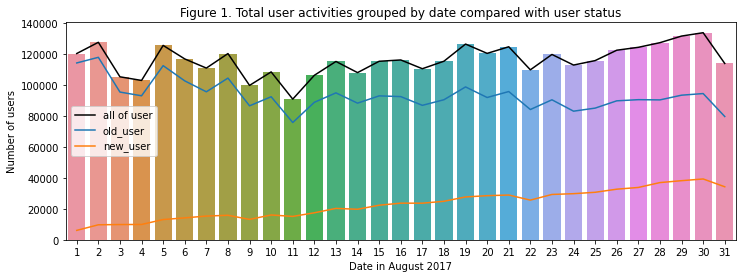

In [12]:
# sql for all users
# fetch('SELECT dt, count(*) FROM ljoin_dataset GROUP BY 1')

# sql for old users
# fetch('SELECT dt, count(*) FROM ljoin_dataset  WHERE join_dt IS NULL GROUP BY 1')

# sql for new users
# fetch('SELECT dt, count(*) FROM ljoin_dataset  WHERE join_dt IS NOT NULL GROUP BY 1')

all_user = df[['dt','user_id']].groupby(['dt']).count().reset_index()
temp = df[['dt','status','user_id']].groupby(['dt','status']).count().reset_index()
temp_o = temp[temp.status=='old_user'].reset_index(drop=1)
temp_n = temp[temp.status=='new_user'].reset_index(drop=1)

plt.figure(figsize=(12,4))
plt.title('Figure 1. Total user activities grouped by date compared with user status')
sns.lineplot(x = all_user.index, y = all_user.user_id, label='all of user', color='black')
# sns.barplot(x = all_user.dt, y = all_user.user_id)
sns.lineplot(x = all_user.index, y = temp_o.user_id, label='old_user')
sns.lineplot(x = all_user.index, y = temp_n.user_id, label='new_user')
sns.barplot(x = np.arange(1,32), y = all_user.user_id)
plt.xlabel('Date in August 2017')
plt.ylabel('Number of users')
plt.grid(False)
plt.show()

#### In the two first days of August number of users activities is a bit high. But, then it experiences fluctuation and constatly increases by the end of month. Conversely, total of daily new user activities rapidly increase, but it experiences decreasing by the lastest day in August 2017 which fall on Thursday.

### 3.1.3. Average of user activity grouped by weekday

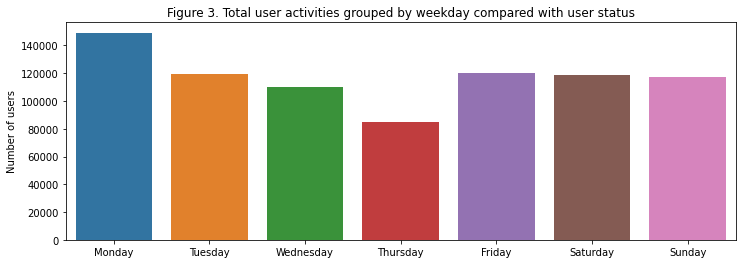

In [14]:
all_user['divisor'] = 4
all_user['divisor'][all_user.day=="Tuesday"] = 5
all_user['divisor'][all_user.day=="Wednesday"] = 5
all_user['divisor'][all_user.day=="Thursday"] = 5
all_user['average_user_act'] = all_user.user_id/all_user.divisor

plt.figure(figsize=(12,4))
plt.title('Figure 3. Total user activities grouped by weekday compared with user status')
sns.barplot(x=all_user.day,y=all_user.average_user_act, 
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.xlabel(None)
plt.ylabel('Number of users')
plt.show()

#### So, basically based on the bar chart above we can conclude that on Monday the number of user activity is the highest from all days and on Thursday the number gets the lowest level while on the rest day number of user activities tends to be constant.

### 3.1.5. Total user activities grouped weekly compared with user status

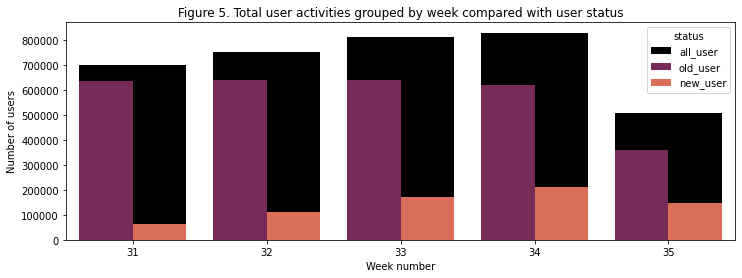

In [16]:
# all user
# fetch(SELECT day, count(*) FROM (SELECT dt, weekday(dt) AS day FROM ljoin_dataset) AS a GROUP BY 1)

# old user
# fetch(SELECT day, count(*) 
#       FROM (SELECT dt, weekday(dt) AS day FROM ljoin_dataset WHERE join_dt IS NULL) AS a GROUP BY 1)

# new user
# fetch(SELECT day, count(*) 
#       FROM (SELECT dt, weekday(dt) AS day FROM ljoin_dataset WHERE join_dt IS NOT NULL) AS a GROUP BY 1)

temp = df[['week','user_id','status']].groupby(['week','status']).count().reset_index()
all_user = df[['week','user_id']].groupby('week').count().reset_index()

plt.figure(figsize=(12,4))
plt.title('Figure 5. Total user activities grouped by week compared with user status')
sns.barplot(x=all_user.week,y=all_user.user_id, color='black', label='all_user')
sns.barplot(x=temp.week,y=temp.user_id, hue=temp.status, hue_order=['old_user','new_user'], palette="rocket")
plt.xlabel('Week number')
plt.ylabel('Number of users')
plt.show()

#### In weekly report we can see that number of user activities constantly increase. In the week 35th looks low due to truncated by the day in the following month that we didn't have data about it.

### 3.1.6. Total user activities grouped weekly compared with weekdays

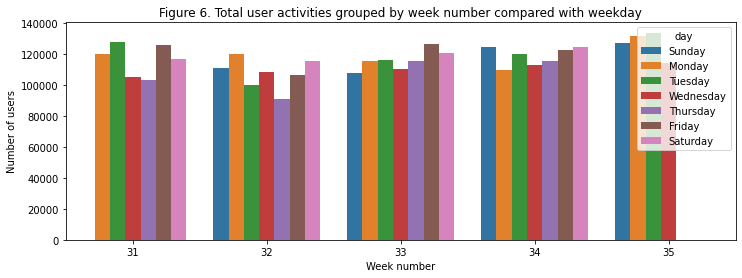

In [17]:
# all user
# fetch(SELECT day, count(*) FROM (SELECT dt, weekday(dt) AS day FROM ljoin_dataset) AS a GROUP BY 1)

# old user
# fetch(SELECT day, count(*) 
#       FROM (SELECT dt, weekday(dt) AS day FROM ljoin_dataset WHERE join_dt IS NULL) AS a GROUP BY 1)

# new user
# fetch(SELECT day, count(*) 
#       FROM (SELECT dt, weekday(dt) AS day FROM ljoin_dataset WHERE join_dt IS NOT NULL) AS a GROUP BY 1)

temp = df[['week','user_id','status','day']].groupby(['week','status','day']).count().reset_index()
all_user = df[['week','user_id','day']].groupby(['week','day']).count().reset_index()

plt.figure(figsize=(12,4))
plt.title('Figure 6. Total user activities grouped by week number compared with weekday')
sns.barplot(x=all_user.week,y=all_user.user_id, hue=all_user.day, hue_order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
plt.xlabel('Week number')
plt.ylabel('Number of users')
plt.show()

#### In the 2 first weeks number of user activities tend to decreasing by Thursday. Meanwhile in the following week number constantly increases as it goes to weekend.

### 3.1.7. Total user activities grouped by daylight 6AM/night 6PM

### 3.1.8 User activity distribution

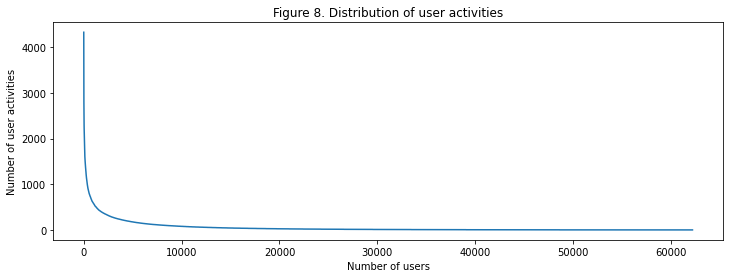

In [19]:
temp = df.groupby('user_id').count().reset_index()[['user_id','dt']].sort_values('dt',ascending=0).reset_index(drop=1)

plt.figure(figsize=(12,4))
plt.title('Figure 8. Distribution of user activities')
sns.lineplot(x = np.arange(len(temp.dt)), y = temp.dt)
plt.xlabel('Number of users')
plt.ylabel('Number of user activities')
plt.show()

#### Around 1000 users have around 1000 activities While the rest users only have less than 1000 activities in August 2017. We will try to find out the precise number as following sub section.

### 3.1.9. More on user activity distribution

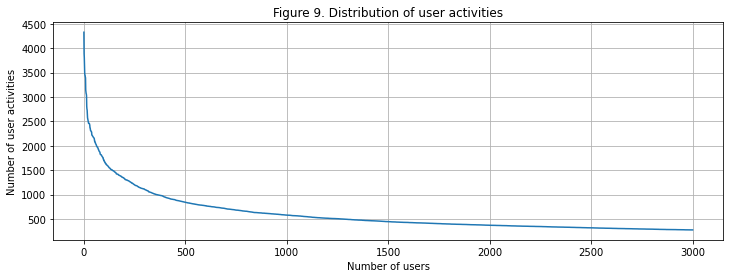

In [53]:
temp = df.groupby('user_id').count().reset_index()[['user_id','dt']].sort_values('dt',ascending=0).reset_index(drop=1)
temp = temp[:3000]

plt.figure(figsize=(12,4))
plt.title('Figure 9. Distribution of user activities')
sns.lineplot(x = np.arange(len(temp.dt)), y = temp.dt)
plt.xlabel('Number of users')
plt.ylabel('Number of user activities')
plt.grid(1)
plt.show()

#### Apparently, number uf user with more than 1000 activities in August 2017 is around 400 users.

### 3.1.10 Number of session each user distribution

### 3.1.11 Number of screen_id each user distribution

## 3.2 New Users Analysis


#### Remark. We call new user as user who joined in August 2017

#### Data Preprocessing for dataset2

In [21]:
def new_user_preprocessing(df):
    df.user_id = df.user_id.map(lambda x : str(x))
    df.join_dt = pd.to_datetime(df.join_dt)
    
    # create new field "join_day" to get the weekday of each day
    df['join_wday'] = df.join_dt.map(lambda x : x.weekday())
    df['join_wday'][df.join_wday==0] = 'Sunday'
    df['join_wday'][df.join_wday==1] = 'Monday'
    df['join_wday'][df.join_wday==2] = 'Tuesday'
    df['join_wday'][df.join_wday==3] = 'Wednesday'
    df['join_wday'][df.join_wday==4] = 'Thursday'
    df['join_wday'][df.join_wday==5] = 'Friday'
    df['join_wday'][df.join_wday==6] = 'Saturday'
    
    # create new field "join_week" 
    df['join_week'] = df.join_dt.map(lambda x : int(datetime.date(int(x.year), int(x.month), int(x.day)).strftime('%W')))

    # change brand field type into lowercase
    df.brand[df.brand.isna()==False] = df.brand.map(lambda x : str(x).lower())
    
    return df

df2 = new_user_preprocessing(df2)

### 3.2.1. Total number of new users grouped by day

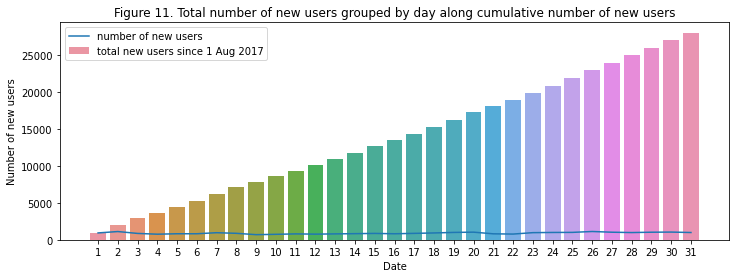

In [22]:
# fetching("SELECT join_dt, count(*) FROM dataset2 GROUP BY 1")

temp = df2[['join_dt','user_id']].groupby('join_dt').count().reset_index()
temp['cum'] = temp.user_id[0]
for i in range(1,len(temp)):
    temp.cum[i] = temp.user_id[i]+temp.cum[i-1]

plt.figure(figsize=(12,4))
plt.title('Figure 11. Total number of new users grouped by day along cumulative number of new users')
sns.barplot(data=temp, x = np.arange(1,32), y='cum', label='total new users since 1 Aug 2017')
sns.lineplot(data=temp, x=temp.index, y='user_id', label='number of new users')
plt.xlabel('Date')
plt.ylabel('Number of new users')
plt.show()

### 3.2.2 We zoom the lineplot above to see number of new users each day

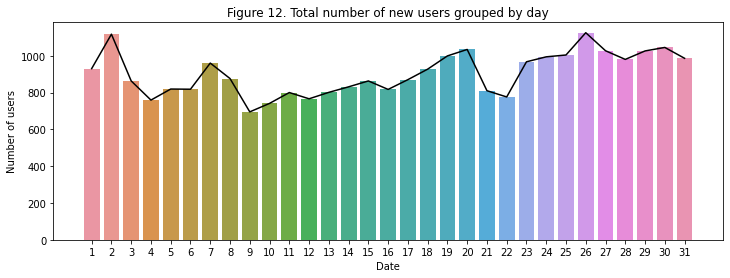

In [23]:
temp = df2[['join_dt','user_id']].groupby('join_dt').count().reset_index()
temp['cum'] = temp.user_id[0]
for i in range(1,len(temp)):
    temp.cum[i] = temp.user_id[i]+temp.cum[i-1]

plt.figure(figsize=(12,4))
plt.title('Figure 12. Total number of new users grouped by day')
sns.barplot(data=temp, x = np.arange(1,32), y='user_id')
sns.lineplot(data=temp, x = temp.index, y='user_id', color='black')
plt.xlabel('Date')
plt.ylabel('Number of users')
# plt.grid(True)
plt.show()

#### Number of new users constantly increase day by day until end of August 2017. But, dramatically it also decreases to the lower level on 4, 9, 22, 23 August 2017.

### 3.2.2. Total number of new users grouped by week

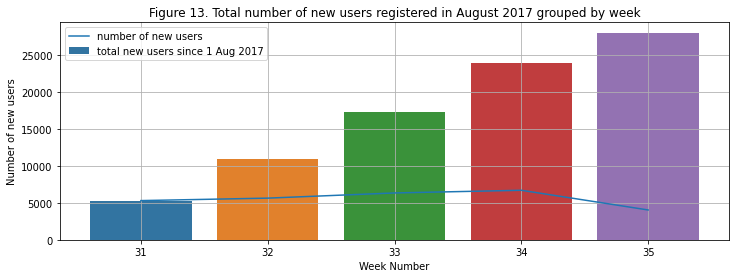

In [24]:
# fetching("SELECT WEEK(join_dt), count(*) FROM ds2 GROUP BY 1 ORDER BY 1")

temp = df2[['join_week','user_id']].groupby('join_week').count().reset_index()
temp['cum'] = temp.user_id[0]
for i in range(1,len(temp)):
    temp.cum[i] = temp.user_id[i]+temp.cum[i-1]

plt.figure(figsize=(12,4))
plt.title('Figure 13. Total number of new users registered in August 2017 grouped by week')
sns.barplot(data=temp, x='join_week', y='cum', label='total new users since 1 Aug 2017')
sns.lineplot(data=temp, x=temp.index, y='user_id', label='number of new users')
plt.xlabel('Week Number')
plt.ylabel('Number of new users')
plt.grid(True)
plt.show()

#### In weekly display, number of new users constantly increase. In the picture above in the week 35th the graphic looks decreasing due to truncated by the month after that we don't have data about it. 

### 3.2.3. Total number of new users grouped by weekdays

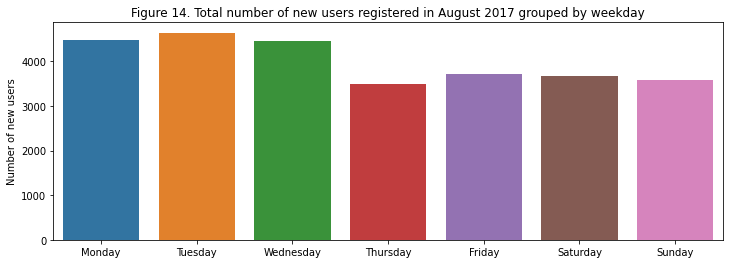

In [27]:
# fetching("SELECT WEEKDAY(join_dt), COUNT(*) FROM ds2 GROUP BY 1")

temp = df2[['join_wday','user_id']].groupby('join_wday').count().reset_index()
plt.figure(figsize=(12,4))
plt.title('Figure 14. Total number of new users registered in August 2017 grouped by weekday')
sns.barplot(data=temp, x='join_wday', y='user_id',  order=['Monday','Tuesday','Wednesday',
                                                           'Thursday','Friday','Saturday','Sunday'])
plt.xlabel(None)
plt.ylabel('Number of new users')
plt.show()

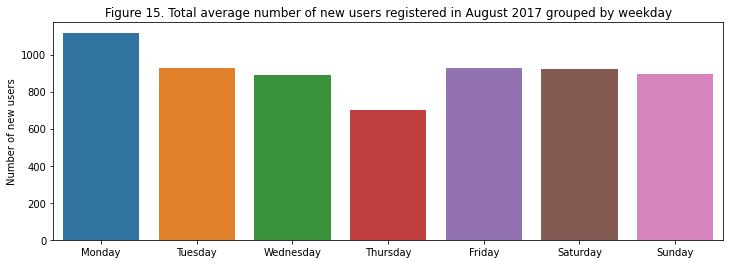

In [46]:
temp = df2[['join_wday','user_id']].groupby('join_wday').count().reset_index()
temp['divisor'] = 4
temp['divisor'][temp.join_wday=="Tuesday"] = 5
temp['divisor'][temp.join_wday=="Wednesday"] = 5
temp['divisor'][temp.join_wday=="Thursday"] = 5
temp['average_no_new_user'] = temp.user_id/temp.divisor

plt.figure(figsize=(12,4))
plt.title('Figure 15. Total average number of new users registered in August 2017 grouped by weekday')
sns.barplot(data=temp, x='join_wday', y='average_no_new_user', order=['Monday','Tuesday','Wednesday',
                                                           'Thursday','Friday','Saturday','Sunday'])
plt.xlabel(None)
plt.ylabel('Number of new users')
plt.show()

#### Number of new users joined on Monday is the highest one and number of new users joined on Thursday is the lowest one. This graphis is almost similar with average number of user activities in sub section 3.1.3.

### 3.2.4. Top 20 brands used by new users for registering/ join

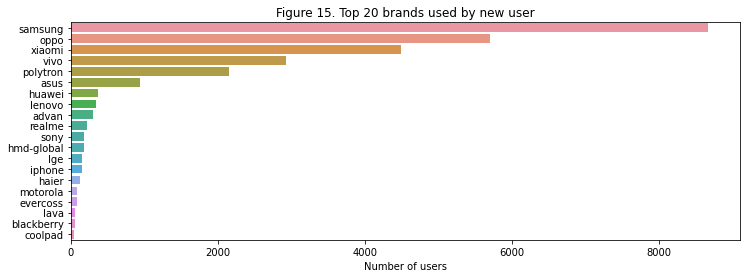

In [26]:
# fetch("SELECT LOWER(brand), COUNT(*) FROM ds2 GROUP BY 1 ORDER BY 2 DESC, 1 ASC LIMIT 20 ")

temp = df2.groupby('brand').count().reset_index()[['brand','user_id']].sort_values('user_id',ascending=0).head(20)
plt.figure(figsize=(12,4))
plt.title('Figure 15. Top 20 brands used by new user')
sns.barplot(temp.user_id, temp.brand)
plt.ylabel(None)
plt.xlabel('Number of users')
plt.show()

#### Almost a third of new users using samsung device to join, followed with oppo and xiaomi devices.

### 4. Conclusion

#### We have two datasets, the first one is dataset on user activities in August 2017 and the another one is dataset on new registered user containing dates and device brands in August 2017. 

#### Based on the dataset, by end of August 2017 the are 62.210 active users with 28.024 of them we categorized as new users.


#### Generally, we can conclude that number of new users constantly improves day by day. The average number of new users and average number of user activities get the highest level on Monday while they get the lowest level on Thursday. Meanwhile on the rest days, they tends to be constant. Besides that, we noticed that mostly of these new users (a third of them) come from samsung device user.

#### Besides that from 62.210 active users, around 400 of them have number of activities more than 1000. While the rest of them are still lower than 1000 activities. Let's say minimum activity in one day is 10, then for one month the minimum number of activity of each user is around 300. So, number of user that passes the minimum 300 activity based on the graphic above is around 3000 which means around 5% of total users.